### Libraries and data loading

In [1]:
!pip install CRPS


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import math
import matplotlib.dates as mdates
import numpy.ma as ma
import CRPS.CRPS as pscore
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
writer = SummaryWriter()

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
print(torch.__version__)
# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

# Get GPU name
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2.7.1+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 4070 Ti


In [10]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(cwd,"data")
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')

# !change model name for different models!
model_name = 'UNet_sky_image_PV_mapping'
output_folder = os.path.join(cwd,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: c:\Users\aiden\OneDrive\Documents\PVOutputPrediction\data
data_path: c:\Users\aiden\OneDrive\Documents\PVOutputPrediction\data\video_prediction_dataset.hdf5
output_folder: c:\Users\aiden\OneDrive\Documents\PVOutputPrediction\model_output\UNet_sky_image_PV_mapping


In [5]:
# # generate handler for the hdf5 data
# forecast_dataset = h5py.File(data_path, 'r')

# # show structure of the hdf5 data
# def get_all(name):
#     if name!=None:
#         print(forecast_dataset[name])

# forecast_dataset.visit(get_all)

In [6]:
# from datasets import load_dataset

# ds = load_dataset("skyimagenet/SKIPPD")

# images_train =[]
# pv_train = []
# times_train = []
# images_test =[]
# pv_test = []
# times_test = []
# for mode in ["train", "test"]:
    # globals()[f'images_{mode}'].append(np.array(ds[mode][:]['image']))
    # globals()[f'pv_{mode}'].append(ds[mode][:]['pv'])
    # globals()[f'times_{mode}'] = ds[mode][:]['time']

# for mode in ["train", "test"]:
#     globals()[f'images_{mode}'] = np.array(globals()[f'images_{mode}'])
#     globals()[f'pv_{mode}'] = np.array(globals()[f'pv_{mode}'] )
    
# images_train = np.squeeze(images_train)
# pv_train = np.squeeze(pv_train)
# times_train = np.squeeze(times_train)

# images_test = np.squeeze(images_test)
# pv_test = np.squeeze(pv_test)
# times_test = np.squeeze(times_test)

In [7]:
# np.save("times_train.npy", np.array(times_train))
# np.save("times_test.npy", np.array(times_test))

In [16]:
images_trainval = np.load("images_train.npy")
pv_trainval = np.load("pv_train.npy")
times_trainval = np.load("times_train.npy", allow_pickle=True)

# images_test = np.load("images_test.npy")
# pv_test = np.load("pv_test.npy")
# times_test = np.load("times_test.npy", allow_pickle=True)

images_trainval = images_trainval.transpose(0, 3, 1, 2).astype(np.float32)
# images_test = images_test.transpose(0, 3, 1, 2)
images_trainval = torch.from_numpy(images_trainval)
# images_test = torch.from_numpy(images_test).float()
# pv_trainval = torch.from_numpy(pv_trainval).float()
# pv_test = torch.from_numpy(pv_test).float()
# times_trainval = np.squeeze(times_trainval)
# times_test = np.squeeze(times_test)


In [9]:
"""
print('-'*50)
# get the input dimension for constructing the model
# the input images will be reshaped from (None, 8, 64, 64, 3) to (None, 64, 64, 24)
# the Stanford dataset contains 16 log terms, we only take 8 with 2-min interval
# to be consistent with the Cambridge dataset
img_side_len = forecast_dataset['trainval']['images_log'].shape[2]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[4]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)
# !change samplpe fraction for different models! ########
fraction = 1 # get only 10% sample of the whole dataset
#########################################################

num_samples = int(len(times_trainval)*fraction)
times_trainval = times_trainval[:num_samples]
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
print("batch_size:", batch_size)
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    image = forecast_dataset['trainval']['images_log'][idxs]
    print ("shape: ", forecast_dataset['trainval']['images_log'].shape)
    print(image.shape)
    plt.figure(figsize=(6, 6))
    plt.imshow(image[0,10])
    plt.title('3D RGB Image')
    plt.show()
    pv = forecast_dataset['trainval']['pv_log'][idxs]
    print(pv.shape)
    #_ = forecast_dataset['trainval']['pv_pred'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
#forecast_dataset.close()"""

'\nprint(\'-\'*50)\n# get the input dimension for constructing the model\n# the input images will be reshaped from (None, 8, 64, 64, 3) to (None, 64, 64, 24)\n# the Stanford dataset contains 16 log terms, we only take 8 with 2-min interval\n# to be consistent with the Cambridge dataset\nimg_side_len = forecast_dataset[\'trainval\'][\'images_log\'].shape[2]\nnum_color_channel = forecast_dataset[\'trainval\'][\'images_log\'].shape[4]\nimage_input_dim = [img_side_len,img_side_len,num_color_channel]\n\nprint("image side length:", img_side_len)\nprint("number of color channels:", num_color_channel)\nprint("input image dimension:", image_input_dim)\n\n# load time stamps into the memory\ntimes_trainval = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)\n# !change samplpe fraction for different models! ########\nfraction = 1 # get only 10% sample of the whole dataset\n#########################################################\n\nnum_samples = int(len(times_trainval

### Input data pipeline helper functions

In [5]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):

    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [6]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [7]:
def mask_background(img): # put all background pixels (the ones outside the circle region of sky images) to 0s
    mask = np.ones((3,64,64), dtype=bool)
    for i in range(64):
        for j in range(64):
            if (i-30)**2+(j-30)**2>=31**2:
                mask[:,i,j]=0
    mask_img = img*mask
    return mask_img

In [8]:
class PVDataset(Dataset):

    def __init__(self, images, pv, transform=None, target_transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = mask_background(images)
        self.images = self.images/255
        self.pv = pv

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        pv = self.pv[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            pv = self.target_transform(pv)
        return image, pv

In [9]:
def compute_winkler_score(prob_prediction,observation):
    alpha = 0.1
    lb = np.percentile(prob_prediction,5,axis=0)
    ub = np.percentile(prob_prediction,95,axis=0)
    delta = ub-lb
    if observation<lb:
        sc = delta+2*(lb-observation)/alpha
    if observation>ub:
        sc = delta+2*(observation-ub)/alpha
    if (observation>=lb) and (observation<=ub):
        sc = delta
    return sc

### Model architecture

In [10]:
# define training time parameters
num_filters = 12
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 128


In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary

# class Image2PV(nn.Module):
#     def __init__(self):
#         super(Image2PV, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels = 3, out_channels = num_filters, kernel_size = (3,3), padding = 'same')
#         self.conv3x3 = nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=(3,3), padding='same')

#         self.bn = nn.BatchNorm2d(num_filters)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout()
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.upsample = self.Up2x2Conv3x3(num_filters)

#         # Define the convolutional blocks
#         self.block1 = self.Conv3x3block(num_filters)
#         self.block2 = self.Conv3x3block(2 * num_filters)
#         self.block3 = self.Conv3x3block(4 * num_filters)

#         # Define bottleneck blocks
#         self.bottleneck1 = self.BottleNeckBlock(4 * num_filters)
#         self.bottleneck2 = self.BottleNeckBlock(4 * num_filters)

#         # Final layers
#         self.final_conv = nn.Conv2d(in_channels=num_filters, out_channels=1, kernel_size=(1,1), padding='same')
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(num_filters * 64 * 64, 1)
    
#     def Conv3x3block(self, input_channel):
#         def block(X):
#             conv1 = self.conv3x3(X)
#             bn1 = self.bn(input_channel)(conv1)
#             relu1 = self.relu()(bn1)
#             return relu1
#         return block
    
#     def BottleNeckBlock(self, input_channel):
#         def block(X):
#             conv1 = self.conv3x3(X)
#             bn1 = self.bn(input_channel)(conv1)
#             relu1 = self.relu()(bn1)

#             conv2 = self.conv3x3(relu1)
#             bn2 = self.bn(input_channel)(conv2)

#             output = X + bn2
#             return output
#         return block
    
#     def Up2x2Conv3x3(self, input_channel):
#         '''
#         input_channel: number of input channels, a scaler
#         '''
#         def block(X):
#             upsampling = nn.Upsample(size=(2, 2))(X)

#             conv1 = self.conv3x3(upsampling)
#             return conv1
#         return block
    
#     def forward(self, x):
#         output1 = self.conv1(x)
#         output3 = self.block1(output1)

#         output4 = self.maxpool(output3)
#         output6 = self.block2(output4)
        
#         output7 = self.maxpool(output6)
#         output8 = self.block3(output7)

#         output9 = self.bottleneck1(output8)
#         output10 = self.bottleneck2(output9)

#         output11 = self.upsample(output10)
#         output12 = torch.cat((output11, output6), dim=1)

#         output14 = self.block2(output12)
#         output14 = self.dropout(0.4)(output14)

#         output15 = self.upsample(output14)
#         output16 = torch.cat((output15, output3), dim=1)

#         output18 = self.block1(output16)
#         output18 = self.dropout(0.4)(output18)

#         y = self.final_conv(output18)
#         y = self.flatten(y)
#         y_out = self.fc(y)

#         return y_out

# def train(model, device, train_loader, optimizer):
#     model.train()
#     size = len(train_loader.dataset)
#     for batch_idx, (image,pv) in enumerate(train_loader):
#         image, pv = image.to(device), pv.to(device)
        
#         output = model(image)
#         loss = nn.MSELoss(output, pv)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         if batch_idx % 100 == 0:
#             loss, current = loss.item(), batch_idx * batch_size + len(image)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
# # Initialize and print model architecture
# model = Image2PV().to(device)
# summary(model, input_size = ( 3,64,64))
# print(model)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Conv3x3Block(nn.Module):
    """
    Basic convolutional block with Conv2D -> BatchNorm -> ReLU
    """
    def __init__(self, input_channels, output_channels):
        super(Conv3x3Block, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BottleNeckBlock(nn.Module):
    """
    Residual bottleneck block with skip connection
    """
    def __init__(self, channels):
        super(BottleNeckBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + identity  # Skip connection
        return out

class Up2x2Conv3x3(nn.Module):
    """
    Upsampling block with 2x2 upsampling followed by 3x3 convolution
    """
    def __init__(self, input_channels, output_channels):
        super(Up2x2Conv3x3, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    """
    U-Net style architecture for Image-to-PV prediction
    """
    def __init__(self, image_input_dim, num_filters=12):
        super(UNet, self).__init__()

        # Assuming image_input_dim is (height, width, channels)
        # PyTorch uses (channels, height, width)
        if len(image_input_dim) == 3:
            input_channels = image_input_dim[0]  # Assuming CHW format
        else:
            input_channels = image_input_dim[2]  # Assuming HWC format

        # Initial 1x1 convolution
        self.conv1x1_input = nn.Conv2d(input_channels, num_filters, kernel_size=1, padding=0)

        # Encoder (contracting path)
        self.conv3x3_1 = Conv3x3Block(num_filters, num_filters)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_2 = Conv3x3Block(num_filters, 2 * num_filters)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_3 = Conv3x3Block(2 * num_filters, 4 * num_filters)

        # Bottleneck with residual blocks
        self.bottleneck1 = BottleNeckBlock(4 * num_filters)
        self.bottleneck2 = BottleNeckBlock(4 * num_filters)

        # Decoder (expanding path)
        self.up1 = Up2x2Conv3x3(4 * num_filters, 2 * num_filters)
        self.conv3x3_4 = Conv3x3Block(4 * num_filters, 2 * num_filters)  # After concatenation
        self.dropout1 = nn.Dropout2d(0.4)

        self.up2 = Up2x2Conv3x3(2 * num_filters, num_filters)
        self.conv3x3_5 = Conv3x3Block(2 * num_filters, num_filters)  # After concatenation
        self.dropout2 = nn.Dropout2d(0.4)

        # Final 1x1 convolution and output
        self.conv1x1_output = nn.Conv2d(num_filters, 1, kernel_size=1, padding=0)
        self.relu_final = nn.ReLU(inplace=True)

        # Global average pooling and final dense layer
        self.flatten = nn.Flatten()
        self.final_dense = nn.Linear(4096, 1)

    def forward(self, x):
        # Initial 1x1 convolution
        x = self.conv1x1_input(x)

        # Encoder path
        # First level
        skip1 = self.conv3x3_1(x)  # Save for skip connection
        x = self.maxpool1(skip1)

        # Second level
        skip2 = self.conv3x3_2(x)  # Save for skip connection
        x = self.maxpool2(skip2)

        # Third level
        x = self.conv3x3_3(x)

        # Bottleneck
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)

        # Decoder path
        # First upsampling
        x = self.up1(x)
        x = torch.cat([x, skip2], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_4(x)
        x = self.dropout1(x)

        # Second upsampling
        x = self.up2(x)
        x = torch.cat([x, skip1], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_5(x)
        x = self.dropout2(x)

        # Final output
        x = self.conv1x1_output(x)
        x = self.relu_final(x)

        # Global pooling and final prediction
        x = self.flatten(x)
        x = self.final_dense(x)

        return x

# Example usage
def create_model(image_input_dim=(3, 64, 64), num_filters=num_filters):
    """
    Create the UNet model

    Args:
        image_input_dim: Input image dimensions (C, H, W) for PyTorch
        num_filters: Number of base filters

    Returns:
        PyTorch model
    """
    model = UNet(image_input_dim, num_filters)
    return model

# Example instantiation and summary
if __name__ == "__main__":
    # Assuming 64x64 RGB images
    model = create_model(image_input_dim=(3, 64, 64), num_filters=num_filters).to(device)
    
    # Print model summary
    print(model)

    # Test with dummy input
    dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batch size 1, 3 channels, 64x64
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    summary(model, input_size = (3,64,64))

def trainval(model, device, loader, optimizer, criterion, mode="train"):
    
    if mode == "train":
        model.train()
    else:
        model.eval()
        
    size = len(loader.dataset)
         
    total_loss = 0
    for batch_idx, (image,pv) in enumerate(loader):
        image, pv = image.to(device), pv.to(device)
        
        output = model(image)
        loss = criterion(output, pv)
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        total_loss += loss.item()
    total_loss = total_loss / size
    return total_loss
    

UNet(
  (conv1x1_input): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv3x3_1): Conv3x3Block(
    (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3x3_2): Conv3x3Block(
    (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3x3_3): Conv3x3Block(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (bottleneck1): BottleNeckBlock(
    (conv1): Conv2

In [13]:
criterion = nn.MSELoss()
initial_learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr = initial_learning_rate)

def checkpoint(model, filename):
	torch.save(model.state_dict(), filename)

def resume(model, filename):
	model.load_state_dict(torch.load(filename))

scheduler = lr_scheduler.ExponentialLR(optimizer, 0.933)

indices_dayblock_shuffled = day_block_shuffle(times_trainval)

train_loss_hist = []
val_loss_hist = []


In [ ]:

for i in range (num_fold):
	indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
	images_train = images_trainval[indices_train]
	pv_train = pv_trainval[indices_train]
	images_val = images_trainval[indices_val]
	pv_val = pv_trainval[indices_val]

	train = PVDataset(images_train, pv_train)	
	val = PVDataset(images_val, pv_val)
	train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
	val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

	train_loss_current = []
	val_loss_current = []
	min_loss = 10000

	for j in range(num_epochs):
		
		loss = trainval(model, device, train_loader, optimizer, criterion, mode="train")
		train_loss_current.append(loss)	

		print(f"Epoch {j}: Training Loss = ", loss, )

		if (j % 5 == 0 or j == num_epochs-1):
			loss = trainval(model, device, val_loader, optimizer, criterion, mode="val")
			if loss > val_loss_current[-2] and loss > val_loss_current[-3]:
				break
			if loss < min_loss:
				min_loss = loss
				checkpoint(model, "best_model_repetition_" + str(i+1) + ".pth")
			val_loss_current.append(loss)
			

			print(f"Epoch {j}: Val Loss = ", loss, )
		scheduler.step()
	train_loss_hist.append(train_loss_current)
	val_loss_hist.append(val_loss_current)
	plt.plot(train_loss_hist[i],label='train')
	plt.plot(val_loss_hist[i],label='validation')
	plt.legend()
	plt.show()

np.save(os.path.join(output_folder,'train_loss_hist.npy'),train_loss_hist)
np.save(os.path.join(output_folder,'val_loss_hist.npy'),val_loss_hist)	

### Model training and validation

In [ ]:
def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [35]:
print(images_test.shape)

(1, 14003, 64, 64, 3)


torch.float64
Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


TypeError: Invalid shape (3, 64, 64) for image data

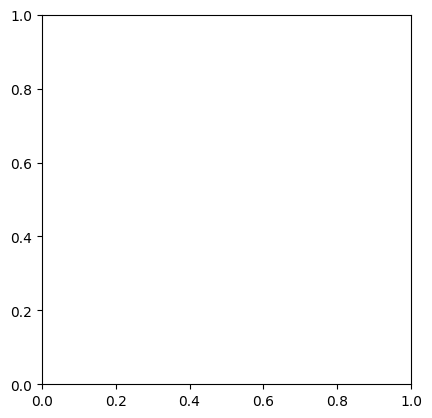

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(train_labels.dtype)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.transpose(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label}")

print(img.dtype)

In [ ]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

### Model Testing with in-range Test Set

Test set data are 10 cloudy days drawn from 2017 March to 2019 October, which is the same range as the training data set.

#### Feeding Real Future Sky Image

In [ ]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

    # normalize image data to [0,1]
    images_data_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
    images_data_test = mask_background(images_data_test)
    pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_data_test.shape:",images_data_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_data_test, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_data_test, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_validation.npy'))

# using the ensemble mean of the 10 models as the final prediction
prediction_ensemble = np.mean(prediction,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [] # you can put sunny days here if you want to test sunny condition performance
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast prediction_ensembles
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1, color=black, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1, label = 'SUNSET forecast',color=red,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.2], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,30)
#plt.savefig(os.path.join(pardir,'results','sunset_forecast_baseline_2017_2019_full_data_trained_2019_test_days.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding ConvLSTM generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_ConvLSTM.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_ConvLSTM_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_PhyDNet.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_PhyDNet_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet+GAN generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_PhyDNetGAN.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_SkyImageGAN_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(5times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding VideoGPT generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_VideoGPT.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images_all_samplings = f['trainval']['images_pred_all_samplings'][:,:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    #predicted_images = mask_background(predicted_images)
    #predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images_all_samplings.shape:",predicted_images_all_samplings.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
num_samplings = 10
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating prediction for sampling {0}'.format(j+1))
        predicted_images = predicted_images_all_samplings[j]
        predicted_images = mask_background(predicted_images)
        predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

        # model evaluation
        #print("evaluating performance for the model".format(i+1))
        loss[i,j] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

        # generate prediction
        #print("generating predictions for the model".format(i+1))
        prediction[i,j] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_VideoGPT_gen_images_as_input.npy'),prediction)

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_validation_VideoGPT_gen_images_as_input.npy'))

In [ ]:
prediction_samp = prediction.reshape(-1,prediction.shape[-1])
prediction_samp.shape
prediction_ensemble = np.mean(prediction_samp,axis=0)

In [ ]:
# evaluate deterministic performance
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print('test rmse for all 10 samplings is {0:3f}'.format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction_samp,25,axis=0)
percent75_prediction = np.percentile(prediction_samp,75,axis=0)
percent5_prediction = np.percentile(prediction_samp,5,axis=0)
percent95_prediction = np.percentile(prediction_samp,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding SkyGPT generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_SkyGPT.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images_all_samplings = f['trainval']['images_pred_all_samplings'][:,:,-1]

print("predicted_images_all_samplings.shape:",predicted_images_all_samplings.shape)

In [ ]:
# evaluate model on the test set and generate predictions
num_samplings = 10
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating prediction for sampling {0}'.format(j+1))
        predicted_images = predicted_images_all_samplings[j]
        #predicted_images = mask_background(predicted_images)
        predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

        # model evaluation
        #print("evaluating performance for the model".format(i+1))
        loss[i,j] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

        # generate prediction
        #print("generating predictions for the model".format(i+1))
        prediction[i,j] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_SkyGPT_gen_images_as_input.npy'),prediction)

In [ ]:
prediction_samp = prediction.reshape(-1,prediction.shape[-1])
prediction_samp.shape
prediction_ensemble = np.mean(prediction_samp,axis=0)

In [ ]:
# evaluate deterministic performance
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print('test rmse for all 10 samplings is {0:3f}'.format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction_samp,25,axis=0)
percent75_prediction = np.percentile(prediction_samp,75,axis=0)
percent5_prediction = np.percentile(prediction_samp,5,axis=0)
percent95_prediction = np.percentile(prediction_samp,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
plt.show()

### Model Testing with Out-range test set

Test set data are 5 cloudy days drawn from 2019 Nov. and Dec., which is the outside the range of the training data set.

#### Feeding Real Future Sky Image

In [ ]:
# load testing data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

model_name = 'UNet_Image_PV_mapping_masked_image'
output_folder = os.path.join(cwd,"model_output", model_name)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    images_log_test = mask_background(images_log_test)
    images_log_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
    pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
#print("pv_pred_test.shape:",pv_pred_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_2019nov_dec.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [] # you can put sunny days here if you want to test sunny condition performance
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
prediction_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
prediction_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding ConvLSTM Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','ConvLSTM','save','ConvLSTM_sky_image_dataset_interval_2min_all_data_v2')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = predicted_image[:,-1]
predicted_image = mask_background(predicted_image)

In [ ]:
predicted_image.shape

In [ ]:
# load testing data
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

# process image data
images_log_test = mask_background(images_log_test)
images_log_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
#print("pv_pred_test.shape:",pv_pred_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_ConvLSTM_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','PhyDNet','save','PhyDNet_sky_image_dataset_interval_2min_all_data_v2')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = mask_background(predicted_image)
predicted_image.shape

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_PhyDNet_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet+GAN Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','PhyDNet','save','PhyDNet_LSGAN_sky_image_dataset_gen_lr_0.001_batch_size_16_model_v2_scheduled_and_reverse_scheduled_sampling_MAE_loss_all_data_v3')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = mask_background(predicted_image)
predicted_image.shape

In [ ]:
plt.imshow(predicted_image[0,0,:,:,::-1])

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_SkyImageGAN_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding VideoGPT Generated Images as Input

We experiment with different number of futures generated, ranging from 1 future to 50 different futures

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','VideoGPT','inference','VideoGPT_2019_test')

In [ ]:
num_samplings = 50
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating predictions for sample {0} ...'.format(j+1))
        # load predicted image samples
        predicted_image = np.load(os.path.join(predicted_image_folder,'sample_'+str(j)+'.npy'),allow_pickle=True)
        print(np.min(predicted_image))
        print(np.max(predicted_image))
        predicted_image = mask_background(predicted_image)

        # model evaluation
        #print("evaluating performance for the model")
        loss[i,j] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=200, verbose=1)

        # generate prediction
        #print("generating predictions for the model")
        prediction[i,j] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'),prediction)

##### Use 1 samplings

In [ ]:
# load testing data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    pv_log_test = f['test']['pv_pred'][:,-1]

print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 1
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 1 sampling
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 1 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 5 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 5
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_5samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 5 samplings for all sub-models".format(loss_rmse_5samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 10 samplings

In [ ]:
use_samp_no = 10
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 10 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]


    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 20 samplings

In [ ]:
use_samp_no = 20
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 30 samplings

In [ ]:
use_samp_no = 30
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 40 samplings

In [ ]:
use_samp_no = 40
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 50 samplings

In [ ]:
use_samp_no = 50
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

#### Feeding SkyGPT Generated Images as Input

Similarly, we experimented with different number of generated future scenarios, ranging from 1 future to 50 futures.

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','SkyGPT','inference','SkyGPT_2019_test')

In [ ]:
num_samplings = 50
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating predictions for sample {0} ...'.format(j+1))
        # load predicted image samples
        predicted_image = np.load(os.path.join(predicted_image_folder,'sample_'+str(j)+'.npy'),allow_pickle=True)

        # scale back all the pixel values back to [0,1] with clipping
        predicted_image = np.clip(predicted_image,-0.5,0.5)+0.5
        predicted_image = mask_background(predicted_image)

        # model evaluation
        #print("evaluating performance for the model")
        loss[i,j] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=200, verbose=1)

        # generate prediction
        #print("generating predictions for the model")
        prediction[i,j] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input_new.npy'),prediction)
    # loss averaged over all samplings for model 1
    #loss_rmse = np.sqrt(np.mean((np.mean(prediction[i],axis=0)-pv_log_test)**2))
    #print("the test set RMSE is {0:.3f} averaged over all samplings for sub-model {1}".format(loss_rmse,i))

##### Use 1 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 1
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_1samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 1 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    #rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_samp[date_mask]))))
    #mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_samp[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_samp[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 5 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input.npy'))
prediction.shape

In [ ]:
use_samp_no = 5
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_5samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 5 samplings for all sub-models".format(loss_rmse_5samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 10 samplings

In [ ]:
use_samp_no = 10
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 10 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 20 samplings

In [ ]:
use_samp_no = 20
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    #rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_samp[date_mask]))))
    #mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_samp[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_samp[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 30 samplings

In [ ]:
use_samp_no = 30
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 40 samplings

In [ ]:
use_samp_no = 40
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")

    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 50 samplings

In [ ]:
use_samp_no = 50
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()